# plot intensity variance vs nuclear size for 3D images


In [3]:
import napari
import torch
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib_scalebar.scalebar import ScaleBar
import gc
import seaborn as sns
from bioio import BioImage
import bioio_nd2
import bioio_tifffile
from bioio.writers import OmeTiffWriter


anisotropy = (3.2,1,1) # Relative scale of (Z,X,Y) axes

nucChannel = 0 # red emerin rings
spotChannel = 1 # green spots

# in lucien's original scripts:
# channel 0 is green spots
# channel 1 is red emerin

pd.set_option('display.max_columns', None)

In [4]:

# on server
base_path = '/mnt/external.data/MeisterLab/jsemple/lhinder/segmentation_Dario/'
base_path = '/Volumes/external.data/MeisterLab/jsemple/lhinder/segmentation_Dario/'
df_paths = pd.DataFrame.from_dict({'data_path': [base_path+'/DPY27/1268/20240915_3d/',
            base_path+'/DPY27/1268/20240814_3d/',
            base_path+'/DPY27/1268/20240808_3d/',
            base_path+'/SDC1/1273/20240813_3d/',
            base_path+'/SDC1/1273/20240821_3d/']})

output_path=base_path+'/DPY27_SDC1_3d/'

if not os.path.exists(output_path+"/plots"):
    os.makedirs(output_path+"/plots")

df=pd.DataFrame()
dist=pd.DataFrame()
for path in df_paths['data_path']:
    df_tmp=pd.read_csv(path+"nuclei_analysis_v001.csv")
    df = pd.concat([df,df_tmp])

df.head()


,label,bb_dimZ,bb_dimY,bb_dimX,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,mean,median,std,sum,variance,max,min,volume,id,zproj_spots,zproj_nuclei,filename,date,experiment,strain,protein,raw_filepath,denoised_filepath
0,1,3,332,196,10.237467,450.775726,209.588391,764.512529,0.087499,121.188654,121.0,9.385192,91861,88.081824,148,99,758,DPY27_3d_20240915_1268_E_bean_15um,[[ 0 126 122 ... 0 0 0]\n [123 125 118 ...,[[ 0 129 126 ... 0 0 0]\n [135 129 136 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...
1,2,13,51,48,17.092244,602.730192,235.823937,48.632410,0.728521,213.400834,205.0,61.361131,2558676,3765.188456,793,105,11990,DPY27_3d_20240915_1268_E_bean_15um,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...
2,3,24,48,58,23.818743,465.149410,405.504229,59.554474,0.738189,227.012229,162.0,143.260306,5959071,20523.515241,1047,99,26250,DPY27_3d_20240915_1268_E_bean_15um,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...
3,4,13,47,42,17.885833,526.404655,261.189650,47.890527,0.919311,208.377154,160.0,116.236053,3205049,13510.819916,854,99,15381,DPY27_3d_20240915_1268_E_bean_15um,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...
4,5,10,47,50,16.749367,537.583875,332.809957,50.926443,0.926797,179.198181,142.0,93.185448,2620415,8683.527708,720,94,14623,DPY27_3d_20240915_1268_E_bean_15um,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...


## Add some variables
Radius might scale more linearly than volume
Coefficient of variation is independent of the mean signal

In [5]:
def radiusFromVolume(volume):
    return (3*volume/(4*np.pi))**(1/3)

def coefficientOfVariation(std,mean):
    return std/mean


df['radius'] = radiusFromVolume(df['volume'])
df['cv'] = coefficientOfVariation(df['std'],df['mean'])
df['zx_ratio'] = (df['bb_dimZ']*anisotropy[0])/(df['bb_dimX']*anisotropy[2])
df['zy_ratio'] = (df['bb_dimZ']*anisotropy[0])/(df['bb_dimY']*anisotropy[1])
df['xy_ratio'] = (df['bb_dimX']*anisotropy[2])/(df['bb_dimY']*anisotropy[1])

df.head()
#sns.scatterplot(data=df, x="volume", y="radius")
#sns.scatterplot(data=df, x="mean", y="std")
#sns.scatterplot(data=df, x="mean", y="cv")

,label,bb_dimZ,bb_dimY,bb_dimX,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,mean,median,std,sum,variance,max,min,volume,id,zproj_spots,zproj_nuclei,filename,date,experiment,strain,protein,raw_filepath,denoised_filepath,radius,cv,zx_ratio,zy_ratio,xy_ratio
0,1,3,332,196,10.237467,450.775726,209.588391,764.512529,0.087499,121.188654,121.0,9.385192,91861,88.081824,148,99,758,DPY27_3d_20240915_1268_E_bean_15um,[[ 0 126 122 ... 0 0 0]\n [123 125 118 ...,[[ 0 129 126 ... 0 0 0]\n [135 129 136 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,5.656227,0.077443,0.048980,0.028916,0.590361
1,2,13,51,48,17.092244,602.730192,235.823937,48.632410,0.728521,213.400834,205.0,61.361131,2558676,3765.188456,793,105,11990,DPY27_3d_20240915_1268_E_bean_15um,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,14.198535,0.287539,0.866667,0.815686,0.941176
2,3,24,48,58,23.818743,465.149410,405.504229,59.554474,0.738189,227.012229,162.0,143.260306,5959071,20523.515241,1047,99,26250,DPY27_3d_20240915_1268_E_bean_15um,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,18.436575,0.631069,1.324138,1.600000,1.208333
3,4,13,47,42,17.885833,526.404655,261.189650,47.890527,0.919311,208.377154,160.0,116.236053,3205049,13510.819916,854,99,15381,DPY27_3d_20240915_1268_E_bean_15um,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,15.427610,0.557816,0.990476,0.885106,0.893617
4,5,10,47,50,16.749367,537.583875,332.809957,50.926443,0.926797,179.198181,142.0,93.185448,2620415,8683.527708,720,94,14623,DPY27_3d_20240915_1268_E_bean_15um,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,15.169897,0.520013,0.640000,0.680851,1.063830


## Filtering and plotting histograms 
Histograms of different variables helps to decide which variables to filter by and with what values 

In [7]:
#filter_indeces = (df['solidity']>=0.5) 
filter_indeces = (df['centroid_z']>=15) & (df['solidity']>=0.85) & (df['solidity']<=1) & (df['xy_ratio']>0.5) & (df['xy_ratio']<1.5) & (df['zx_ratio']>0.4) & (df['zx_ratio']<1.5) & (df['zy_ratio']>0.4) & (df['zy_ratio']<1.5) & (df['filename'].str.contains('dead') == False) 

filt=df[filter_indeces]
filt=filt.reset_index(drop=True)
filt.head()


,label,bb_dimZ,bb_dimY,bb_dimX,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,mean,median,std,sum,variance,max,min,volume,id,zproj_spots,zproj_nuclei,filename,date,experiment,strain,protein,raw_filepath,denoised_filepath,radius,cv,zx_ratio,zy_ratio,xy_ratio
0,4,13,47,42,17.885833,526.404655,261.189650,47.890527,0.919311,208.377154,160.0,116.236053,3205049,13510.819916,854,99,15381,DPY27_3d_20240915_1268_E_bean_15um,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,15.427610,0.557816,0.990476,0.885106,0.893617
1,5,10,47,50,16.749367,537.583875,332.809957,50.926443,0.926797,179.198181,142.0,93.185448,2620415,8683.527708,720,94,14623,DPY27_3d_20240915_1268_E_bean_15um,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,15.169897,0.520013,0.640000,0.680851,1.063830
2,6,9,44,45,16.197679,570.622426,414.887215,47.014676,0.874448,213.524055,152.0,136.668342,2281291,18678.235569,939,99,10684,DPY27_3d_20240915_1268_E_bean_15um,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,13.663074,0.640061,0.640000,0.654545,1.022727
3,9,11,51,48,18.397786,474.739083,458.271501,53.889249,0.923223,212.819040,143.0,162.639126,3518750,26451.485337,1200,96,16534,DPY27_3d_20240915_1268_E_bean_15um,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,15.803858,0.764213,0.733333,0.690196,0.941176
4,10,13,41,40,19.028934,573.256281,275.093179,41.563950,0.895334,196.610173,143.0,129.093455,2527817,16665.120183,873,100,12857,DPY27_3d_20240915_1268_E_bean_15um,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,14.532835,0.656596,1.040000,1.014634,0.975610


In [7]:
df.shape

(41764, 32)

In [8]:
filt.shape

(21038, 32)

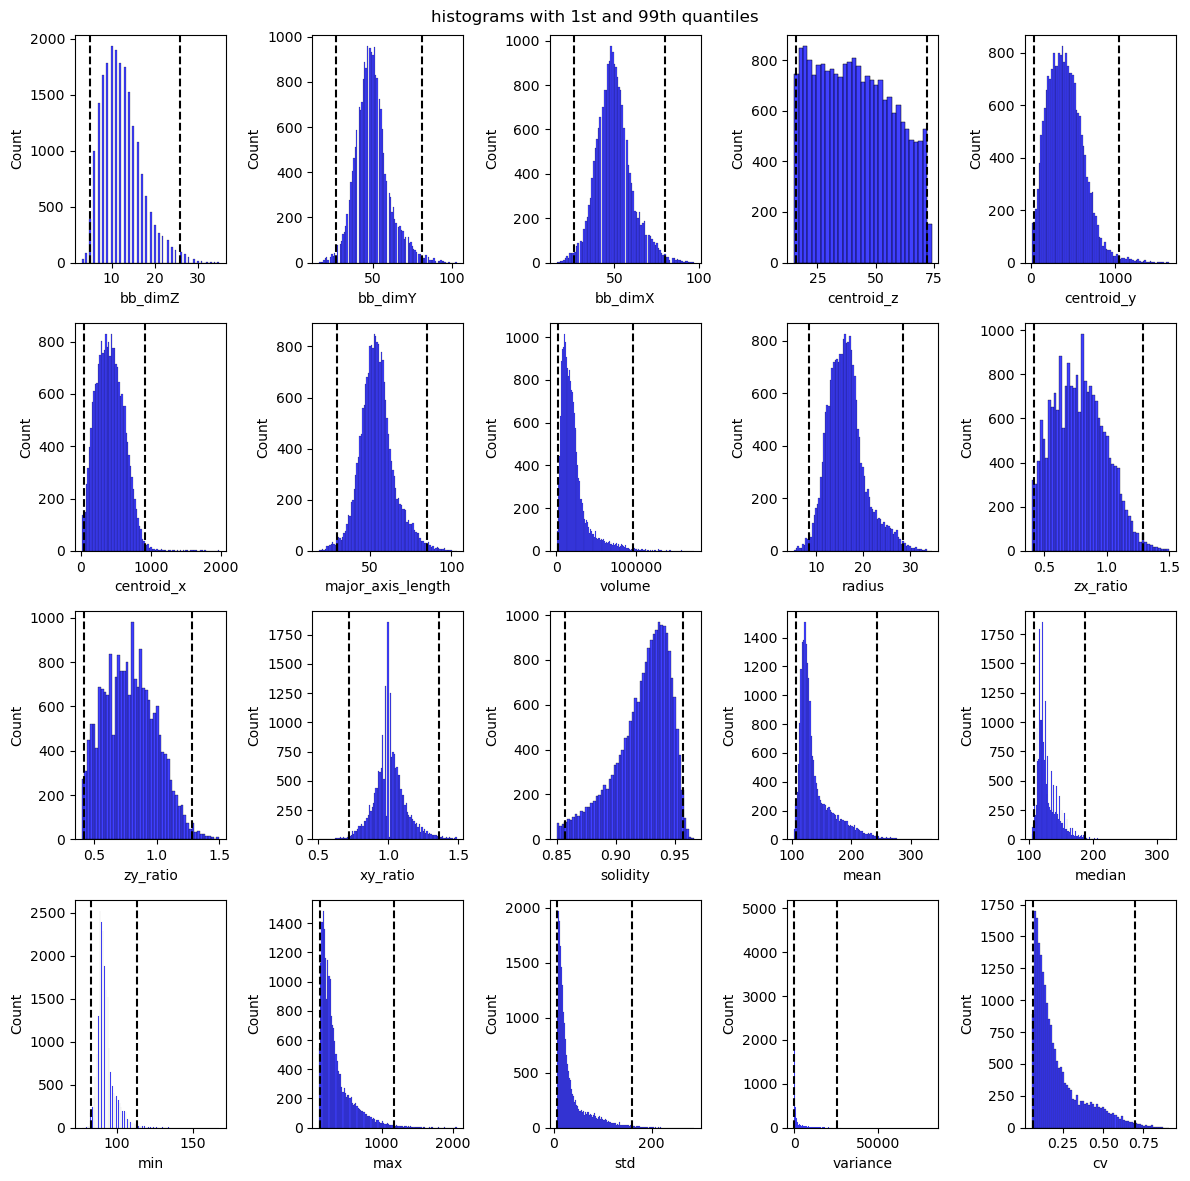

In [9]:
def histogramsOfVariables(df, variables):
    fig, axs = plt.subplots(len(variables)//5+(1 if len(variables)%5>0 else 0), 5, figsize=(12, 12))
    for i, var in enumerate(variables):
        sns.histplot(data=df, x=var, color='blue', ax=axs[i//5, i%5])
        axs[i//5, i%5].axvline(df[var].quantile(0.01), 0, 1, color='black', ls='--')
        axs[i//5, i%5].axvline(df[var].quantile(0.99), 0, 1, color='black', ls='--')
    fig.suptitle("histograms with 1st and 99th quantiles")
    plt.tight_layout()
    plt.show()

quantitativeVars = ["bb_dimZ", "bb_dimY", "bb_dimX", "centroid_z", "centroid_y", "centroid_x", "major_axis_length","volume", "radius", "zx_ratio", "zy_ratio", "xy_ratio", "solidity", "mean", "median", "min","max","std","variance","cv"]
histogramsOfVariables(filt,variables=quantitativeVars)

## Final scatter/regression plots

/var/folders/kz/whz8fzds0l17nwr80rzmymph0000gn/T/ipykernel_96196/2991887180.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


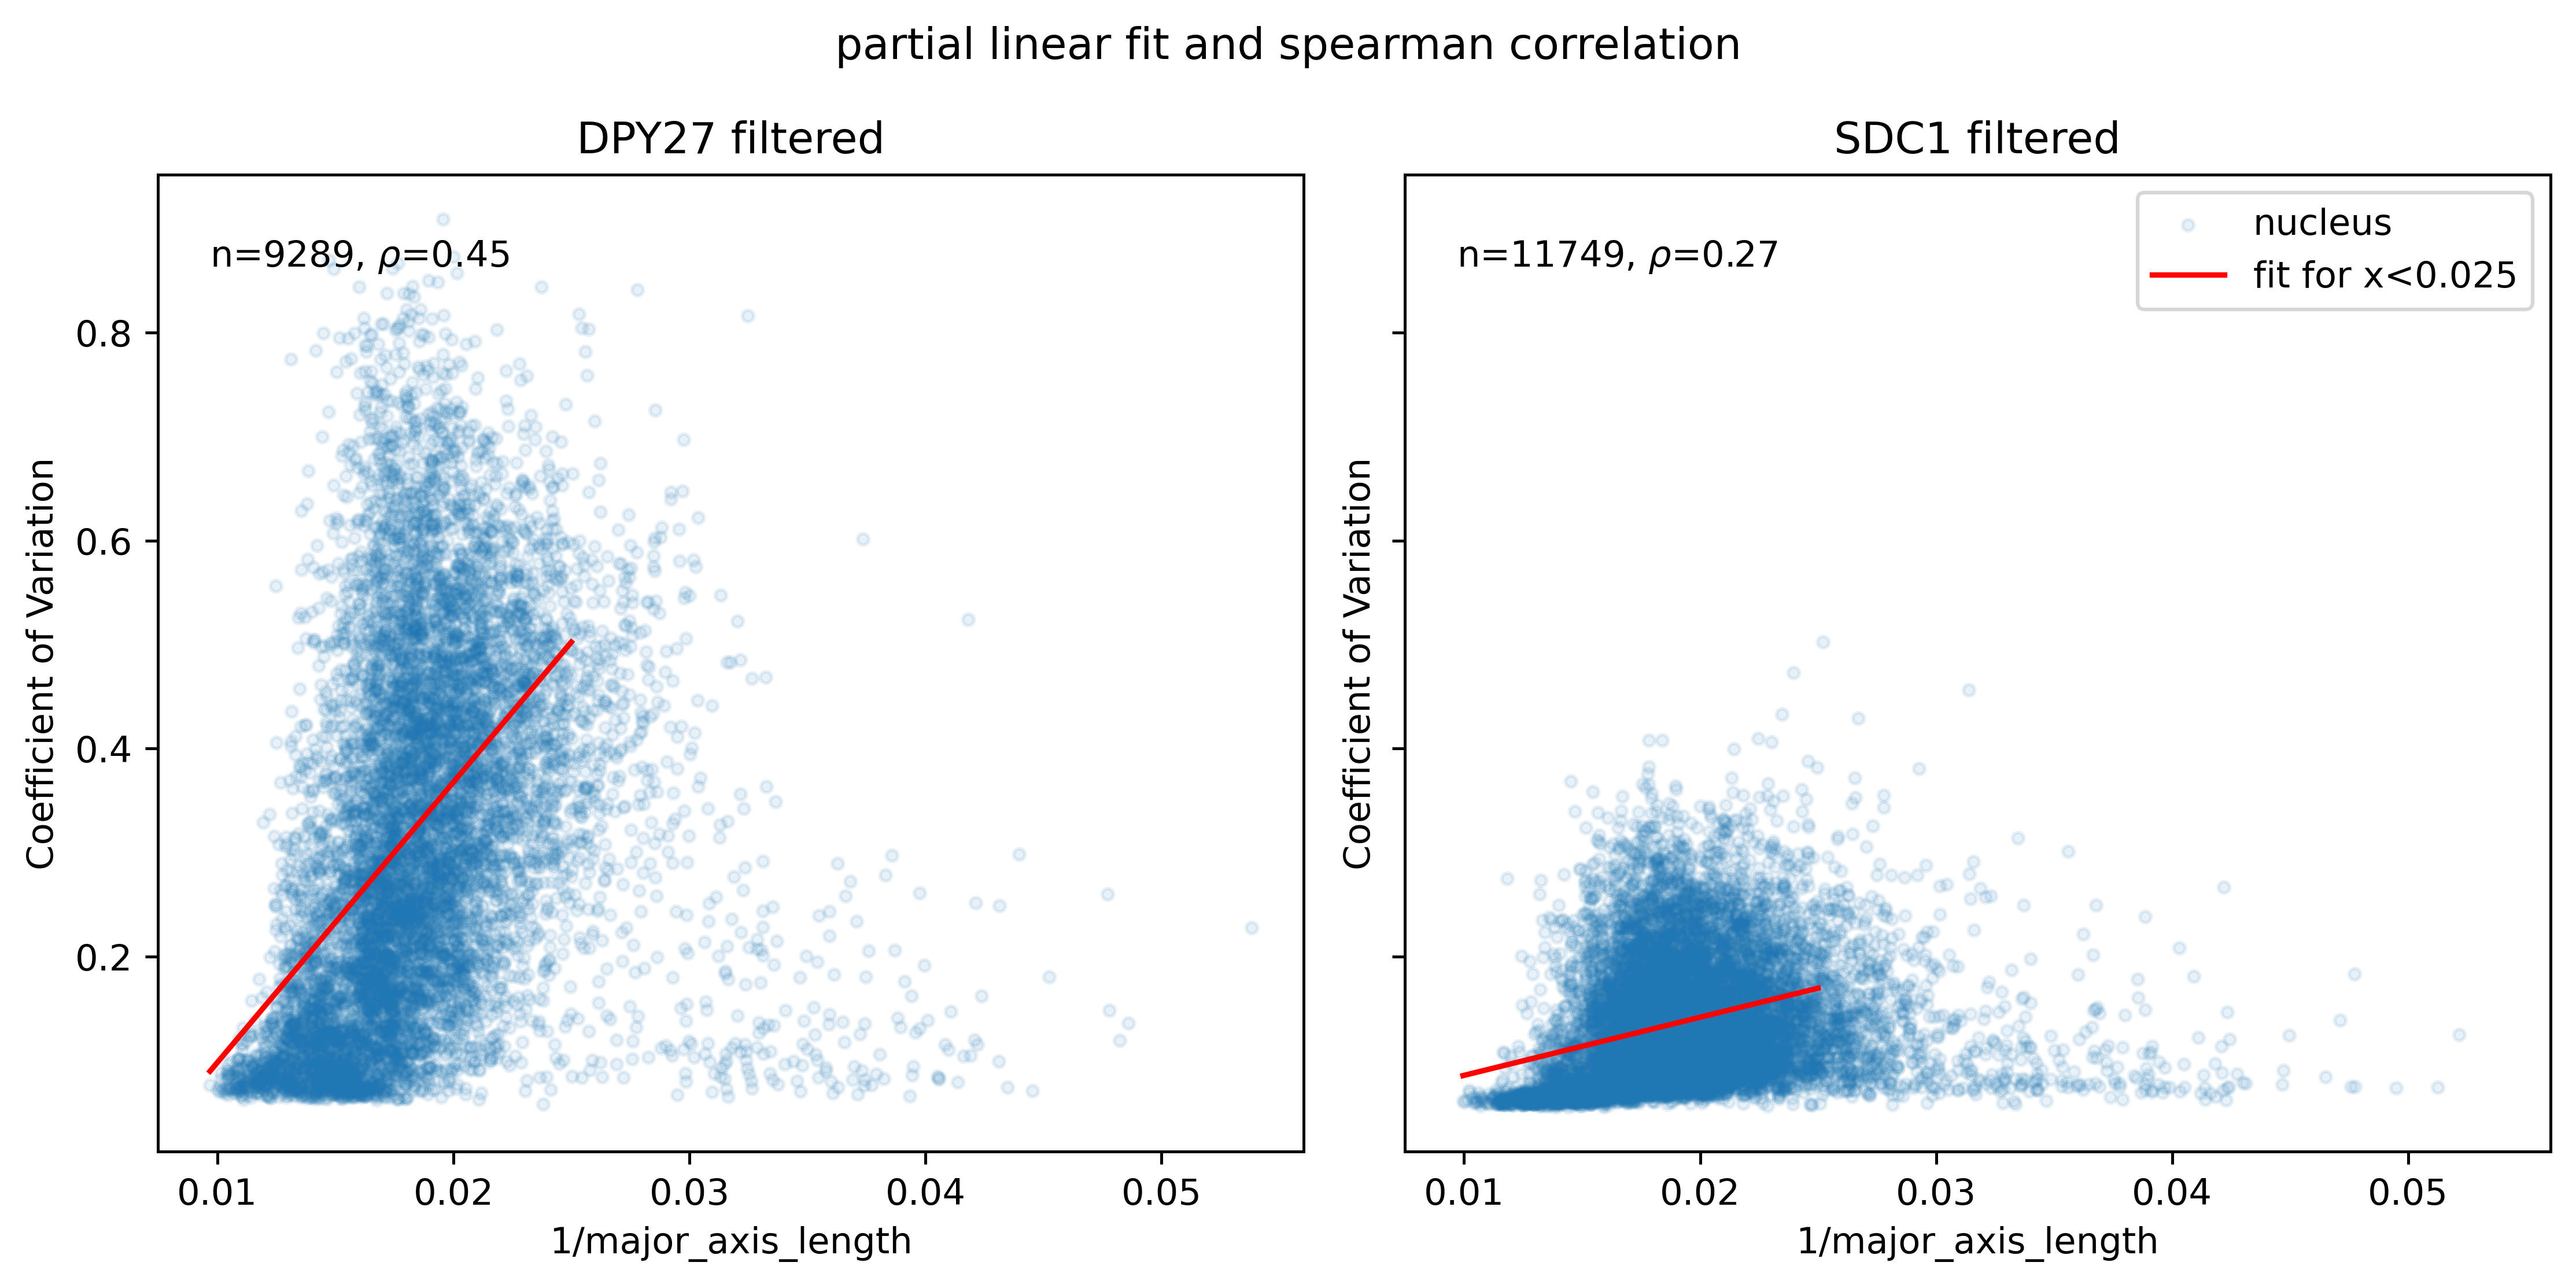

In [69]:
filt['inv_major_axis_length'] = 1/filt['major_axis_length']
filt['inv_log_major_axis_length'] = 1/np.log2(filt['major_axis_length'])
df['inv_log_major_axis_length'] = 1/np.log2(df['major_axis_length'])

xVar = 'inv_major_axis_length'
yVar = 'cv'


def linearfunc(x, a, b):                              
    return a * x + b      

def fitLinearPiece(x, y, xmin=0, xmax=1, initialguess=[1,0.1]):
    mask = np.logical_and(x>xmin, x<xmax)
    fit, covariance = sp.optimize.curve_fit(           
        linearfunc,                                     
        x[mask],   
        y[mask],    
        initialguess)   
    x_fit = np.linspace(x[mask].min(), x[mask].max(), 100)
    y_fit = linearfunc(x_fit, *fit)
    return x_fit, y_fit

def plotCVvsInverseSize(data, proteinsOI=['DPY27','SDC1'],xmin=0,xmax=0.19):
    fig, axs = plt.subplots(1,len(proteinsOI),figsize = (5*len(proteinsOI),5),dpi= 450, sharex=True, sharey=True)
    fig.suptitle('partial linear fit and spearman correlation')
    textPosX=np.min(data[xVar])
    textPosY=np.max(data[yVar])*0.95
    for i,protein in enumerate(proteinsOI):
        ff=data[data['protein']==protein]
        x=np.array(ff[xVar]).reshape(-1,1)
        y=np.array(ff[yVar]).reshape(-1,1)
        x_fit, y_fit = fitLinearPiece(x, y, xmin=xmin, xmax=xmax, initialguess=[1,0.1])
        r, p = sp.stats.spearmanr(a=ff[xVar], b=ff[yVar])
        #sns.regplot(data=ff, x=xVar, y=yVar, scatter_kws={'alpha':0.1,'s':10}, line_kws={'color':'red'},ax=axs[0,i])
        axs[i].scatter(ff[xVar], ff[yVar], label="nucleus",s=10,alpha=0.1)
        axs[i].plot(x_fit, y_fit, c="red", label="fit for x<"+str(xmax))
        axs[i].text(textPosX, textPosY, 'n={:.0f}, '.format(len(ff))+r"$\rho$"+'={:.2f}'.format(r))
        axs[i].set(xlabel='1/major_axis_length', ylabel='Coefficient of Variation', title=protein+' filtered')
        plt.legend()
    plt.tight_layout()
    plt.show()

plotCVvsInverseSize(filt, proteinsOI=['DPY27','SDC1'],xmin=0,xmax=0.025)


